<a href="https://colab.research.google.com/github/covidba/covid/blob/master/covid19_bahia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolução da COVID-19 na Bahia
**Fonte**: http://www.saude.ba.gov.br/temasdesaude/coronavirus/notas-tecnicas-e-boletins-epidemiologicos-covid-19/  
**Dados crus**: https://raw.githubusercontent.com/covidba/covid/master/bahia.csv   
**Github**: https://github.com/covidba/covid

In [1]:
cidade = 'Bahia'
cidade_file_name = 'bahia'
populacao =  14873064
 
import sys
from google.colab import drive
drive.mount('/content/gdrive')
 
#!cd gdrive/My\ Drive && git clone https://github.com/ramonfontes/Mathematical-and-Statistical-Modeling-of-COVID19-in-Brazil/ model
!pip install platypus-opt
!pip install pyswarms==1.1.0
 
#add the path were the models are
sys.path.append("/content/gdrive/My Drive/model/main/")
 
from modelos import SIR

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 102kB 2.5MB/s 


In [0]:
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np
 
data_atual = date.today().strftime("%d-%m-%Y")
url = 'https://raw.githubusercontent.com/covidba/covid/master/%s.csv' % cidade_file_name
df = pd.read_csv(url, usecols=['data', 'confirmados','recuperados', 'mortes']) #, parse_dates=['data'])
df.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes']
df['data'] = pd.to_datetime(df['data'])

In [3]:
#Start the model with population size
model = SIR(tamanhoPop = populacao)
#create a series with the cummulative number of cases
y = df["Casos confirmados"]
#Give the number of days since the day of first case confirmed
x = range(1,len(df["Casos confirmados"]) + 1)
model.fit(x = x, y = y)
#Predict the number of cases
df["Expectativa"] = model.predict(x)

2020-06-04 21:45:40,040 - pyswarms.single.local_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 1}
pyswarms.single.local_best:   0%|          |0/500/content/gdrive/My Drive/model/main/modelos.py:156: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))
pyswarms.single.local_best: 100%|██████████|500/500, best_cost=10.9
2020-06-04 21:47:49,079 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 10.928892546066344, best pos: [ 0.18820874  0.12574024  0.17303942 48.96214973]


In [4]:
#Projections about the future
futherCases = pd.DataFrame.from_dict({"data":pd.date_range(start = df['data'].max()+timedelta(days=1) , end = df['data'].max()+timedelta(days=7))})

df_proj = pd.concat([df,futherCases])
#create the new series to be predicted
predictions = model.predict(df_proj)

/content/gdrive/My Drive/model/main/modelos.py:156: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))


2020-06-04 21:47:53,141 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


,data,Casos confirmados,Casos recuperados,Mortes,Expectativa,Casos ativos,Casos ativos (%)
50,2020-05-16,8314,2151,286,8125.047469,6163,74.1
51,2020-05-17,8443,2199,295,8611.973963,6244,74.0
52,2020-05-18,8581,2407,312,9122.345777,6174,71.9
53,2020-05-19,8636,2803,326,9657.325317,5833,67.5
54,2020-05-20,8820,3216,362,10218.181245,5604,63.5
55,2020-05-21,10632,3523,376,10806.165969,7109,66.9
56,2020-05-22,11085,3679,399,11422.532391,7406,66.8
57,2020-05-23,12849,3934,413,12068.618843,8915,69.4
58,2020-05-24,13709,3965,460,12745.910698,9744,71.1
59,2020-05-25,14058,3965,477,13455.890080,10093,71.8


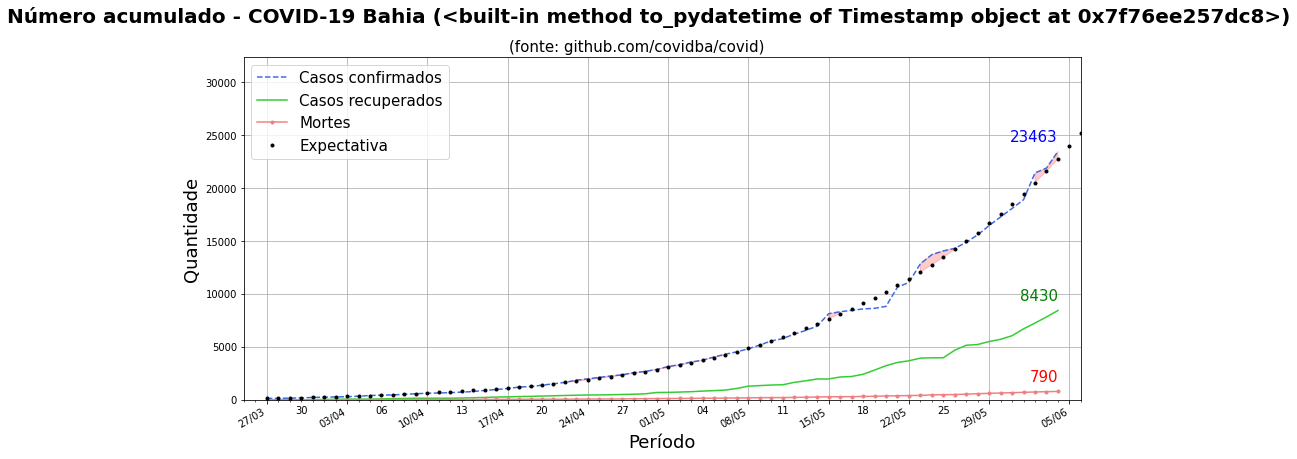

In [5]:
from matplotlib.dates import MO

casos_ativos_diaria = []
for i, v in enumerate(df['Casos confirmados']):
  casos_ativos_diaria.append(v - df['Casos recuperados'][i])
df['Casos ativos'] = casos_ativos_diaria

percentual_casos_ativos_diaria = []
for i, v in enumerate(df['Casos confirmados']):
  percentual_casos_ativos_diaria.append('%.1f' % (df['Casos ativos'][i]*100/v))
df['Casos ativos (%)'] = percentual_casos_ativos_diaria

new_df = df.append(futherCases)
new_df.reset_index(inplace=True, drop=True)
new_df['Expectativa'] = predictions

#set date as index
lista_data = new_df['data']
new_df.set_index('data', inplace=True)

fig, ax = plt.subplots(figsize=(15,7))
colors = ['royalblue','limegreen','lightcoral', 'black']
ls = ['--', '-', '.-', '.']

df2 = new_df
del df2['Casos ativos']
df2.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
#plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# ADICIONAR VALORES
casos_confirmados_series = pd.DataFrame(df2['Casos confirmados'])
ultimo_caso_valido_id = casos_confirmados_series.index.get_loc(casos_confirmados_series.last_valid_index())
def adicionar_valores(caso, color, y=10):
  ax.annotate(int(df2[caso].max()), xy=(lista_data[ultimo_caso_valido_id], df2[caso].max()), 
              xycoords='data', ha='right', fontsize=15, color=color,
              xytext=(0, y), textcoords='offset points')
  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')
#adicionar_valores('Mortes', 'r')

casos_ativos = int(df2['Casos confirmados'].max() - df2['Casos recuperados'].max())
#taxa_mortalidade = (100 * df2['Mortes'].max()) / df2['Casos confirmados'].max()
url_fonte = 'github.com/covidba/covid'

ax.fill_between(new_df.index, new_df['Casos confirmados'], new_df['Expectativa'], 
                where=new_df['Casos confirmados']>=new_df['Expectativa'], alpha=0.2, color='red')

ax.set_ylim(0, new_df['Expectativa'].max())
ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max()-timedelta(days=5)])
fig.suptitle("Número acumulado - COVID-19 %s (%s)" % (cidade, df['data'].max().to_pydatetime), fontsize=20, fontweight='bold')
ax.set_title("(fonte: %s)           " % url_fonte, fontsize=15)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
df.tail(20)

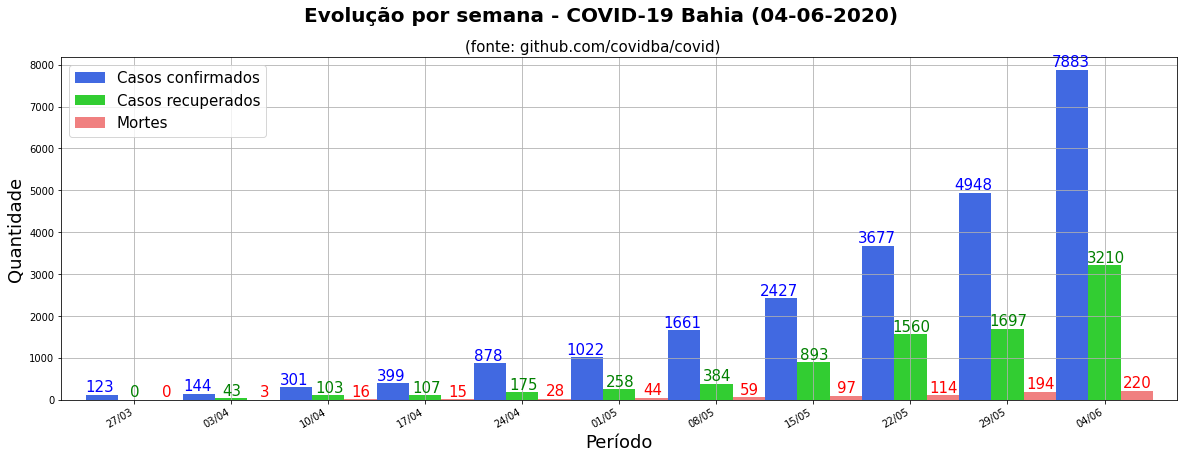

In [6]:
frequencia = 7
colors = ['royalblue','limegreen','lightcoral', 'orange']

dict_diaria = dict()
dict_diaria['data'] = []
dict_diaria['confirmados_diaria'] = []
dict_diaria['recuperados_diaria'] = []
dict_diaria['mortes_diaria'] = []

casos_confirmados_diaria = []
casos_recuperados_diaria = []
casos_mortes_diaria = []

def alimentar_lista(lista, texto):
  for id, v in enumerate(new_df[texto]):
    if not pd.isnull(v):
      if(id) == 0:
        lista.append(v)  
      else:
        lista.append(v - new_df[texto][id-1])
    elif id < len(lista_data)-7:
        lista.append(0)

alimentar_lista(casos_confirmados_diaria, 'Casos confirmados')
alimentar_lista(casos_recuperados_diaria, 'Casos recuperados')
alimentar_lista(casos_mortes_diaria, 'Mortes')

def alimentar_dict(lista, texto):
  soma_casos = 0
  for id, v in enumerate(lista):
    if not pd.isnull(v):
      if id % frequencia == 0:
        if texto == 'confirmados_diaria':
            dict_diaria['data'].append(lista_data[id])
        if id == 0:
          dict_diaria[texto].append(v)
        else:
          if(len(lista)-1 == id):
            dict_diaria[texto].append(soma_casos)
            dict_diaria[texto].append(v)
            if texto == 'confirmados_diaria':
              dict_diaria['data'].append(lista_data.max()+timedelta(days=1))
          else:
            dict_diaria[texto].append(soma_casos)
            soma_casos = v
      else:
        soma_casos += v
        if(len(lista)-1 == id):
          dict_diaria[texto].append(soma_casos)
          if texto == 'confirmados_diaria':
            dict_diaria['data'].append(lista_data[id])

alimentar_dict(casos_confirmados_diaria, 'confirmados_diaria')
alimentar_dict(casos_recuperados_diaria, 'recuperados_diaria')
alimentar_dict(casos_mortes_diaria, 'mortes_diaria')
#alimentar_dict(casos_ativos_diaria, 'ativos_diaria')

df_diaria = pd.DataFrame(dict_diaria)
df_diaria.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes'] #, 'Casos ativos']
novo_df = df_diaria

df_diaria.set_index('data', inplace=True)
fig, ax = plt.subplots(figsize=(20,7))
df_diaria.plot(ax=ax, color=colors, kind='bar', width=1)
fig.autofmt_xdate()

# workaround para erro em bar kind
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df_diaria.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

def plotar_valores(texto, cor, x):
  for i, v in enumerate(df_diaria[texto]):
    if not pd.isnull(v):
      ax.annotate(int(v), xy=(i, v), xycoords='data', ha='center', fontsize=15, color=cor,
                xytext=(x, 3), textcoords='offset points')

plotar_valores('Casos confirmados', 'b', -34)
plotar_valores('Casos recuperados', 'g', 1)
plotar_valores('Mortes', 'r', 33)


ax.set_ylim([0, df_diaria['Casos confirmados'].max() + 300])
fig.suptitle("Evolução por semana - COVID-19 %s (%s)" % (cidade, df['data'].max().strftime("%d-%m-%Y")), fontsize=20, fontweight='bold')
ax.set_title("(fonte: %s)           " % url_fonte, fontsize=15)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

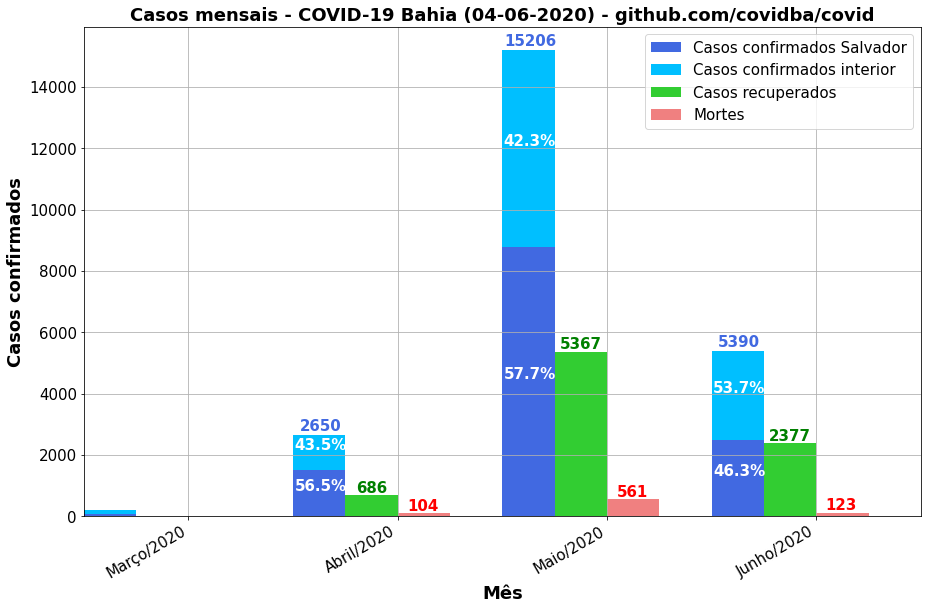

In [12]:
def alimentar_meses(texto, meses, df):
  for id, mes in enumerate(meses.keys()):
    value = df.loc[ max(meses[mes]).strftime("%Y-%m-%d") , texto ]
    number = 0 if pd.isnull(value) else value
    dict_mensal[texto].append(number)
    for i in (range(id)):
      if not pd.isnull(dict_mensal[texto][i]):
        dict_mensal[texto][id] -= dict_mensal[texto][i]

def receber_valores_ssa():
  url = 'https://raw.githubusercontent.com/covidba/covid/master/salvador.csv'
  df_ssa = pd.read_csv(url, usecols=['data', 'confirmados','recuperados', 'mortes_residencia', 'mortes_ocorrencia', 'restricao']) #, parse_dates=['data'])
  df_ssa.columns = ['data', 'Casos confirmados Salvador', 'Casos recuperados', 'Mortes', 'Mortes ocorrência', 'Medida restritiva']
  df_ssa.set_index('data', inplace=True)

  del df_ssa['Mortes ocorrência']
  del df_ssa['Medida restritiva']

  march = pd.date_range(lista_data[0], periods=3) # Março
  april = pd.date_range(lista_data[3], periods=30) # Abril
  may = pd.date_range(lista_data[33], periods=31) # Maio
  june = pd.date_range(lista_data[64], periods=4) # Junho

  meses = {'Março': march, 'Abril': april, 'Maio': may, 'Junho': june}
  alimentar_meses('Casos confirmados Salvador', meses, df_ssa)

colors = ['b','g','r', 'orange']
march = pd.date_range(lista_data[0], periods=5) # Março
april = pd.date_range(lista_data[5], periods=30) # Abril
may = pd.date_range(lista_data[35], periods=31) # Maio
june = pd.date_range(lista_data[66], periods=4) # Junho

meses = {'Março': march, 'Abril': april, 'Maio': may, 'Junho': june}
dict_mensal = {'Meses': ['Março/2020', 'Abril/2020', 'Maio/2020', 'Junho/2020']}

dict_mensal['Casos confirmados Salvador'] = []
dict_mensal['Casos confirmados'] = []
dict_mensal['Casos recuperados'] = []
dict_mensal['Mortes'] = []

receber_valores_ssa()

alimentar_meses('Casos confirmados', meses, new_df)
alimentar_meses('Casos recuperados', meses, new_df)
alimentar_meses('Mortes', meses, new_df)

for id, v in enumerate(dict_mensal['Casos confirmados Salvador']):
    dict_mensal['Casos confirmados'][id] -= dict_mensal['Casos confirmados Salvador'][id]

pd_mensal = pd.DataFrame(dict_mensal)
pd_mensal.columns = ['Meses', 'Casos confirmados Salvador', 'Casos confirmados interior', 'Casos recuperados', 'Mortes'] 

pd_mensal.set_index('Meses', inplace=True)
fig, ax = plt.subplots(figsize=(15,10))
pd_mensal[['Casos confirmados Salvador', 'Casos confirmados interior']].plot(ax=ax, color=['royalblue', 'deepskyblue'], kind='bar', width=.25, position=2, stacked=True)
pd_mensal[['Casos recuperados', 'Mortes']].plot(ax=ax, color=['limegreen', 'lightcoral'], kind='bar', width=.5, position=0.5 )
fig.autofmt_xdate()

# workaround para erro em bar kind
#plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(pd_mensal.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

def plotar_valores(texto, cor, x, p=3):
  for i, v in enumerate(dict_mensal[texto]):
    if i > 0:
      if not pd.isnull(v):
        y = v
        if texto == 'Casos confirmados':
          y = int(v + dict_mensal['Casos confirmados Salvador'][i])
          perc = (v * 100 / (dict_mensal['Casos confirmados Salvador'][i] + v))
          v = "%.1f%%" % perc
          ax.annotate(y, xy=(i, y+150), xycoords='data', ha='center', fontsize=15, color='royalblue',
                  xytext=(x, 0), textcoords='offset points', fontweight='bold')
          y = y - dict_mensal['Casos confirmados'][i]/2
        elif texto == 'Casos confirmados Salvador':
          perc = (v * 100 / (dict_mensal['Casos confirmados'][i] + v))
          v = "%.1f%%" % perc
          y = y - dict_mensal['Casos confirmados Salvador'][i]/2
        else:
          v = int(v)
        ax.annotate(v, xy=(i, y), xycoords='data', ha='center', fontsize=15, color=cor,
                  xytext=(x, p), textcoords='offset points', fontweight='bold')

plotar_valores('Casos confirmados Salvador', 'white', -77)
plotar_valores('Casos confirmados', 'white', -77)
plotar_valores('Casos recuperados', 'g', -26)
plotar_valores('Mortes', 'r', 25)

#@ax.set_ylim([0, pd_mensal['Casos confirmados'].max() + 1200])
ax.set_title("Casos mensais - COVID-19 %s (%s) - %s" % (cidade, df['data'].max().strftime("%d-%m-%Y"), url_fonte), fontsize=18, fontweight='bold')
#ax.set_title("(fonte: %s)           " % url_fonte, fontsize=15, va='baseline')
#fig.suptitle("Casos mensais - COVID-19 %s (%s)" % (cidade, df['data'].max().strftime("%d-%m-%Y")), fontsize=20, fontweight='bold')
ax.set_ylabel('Casos confirmados', fontsize=18, fontweight='bold')
ax.set_xlabel('Mês', fontsize=18, fontweight='bold')
ax.grid(True)
plt.savefig('/content/gdrive/My Drive/model/%s-ssa-interior.png' % cidade_file_name)

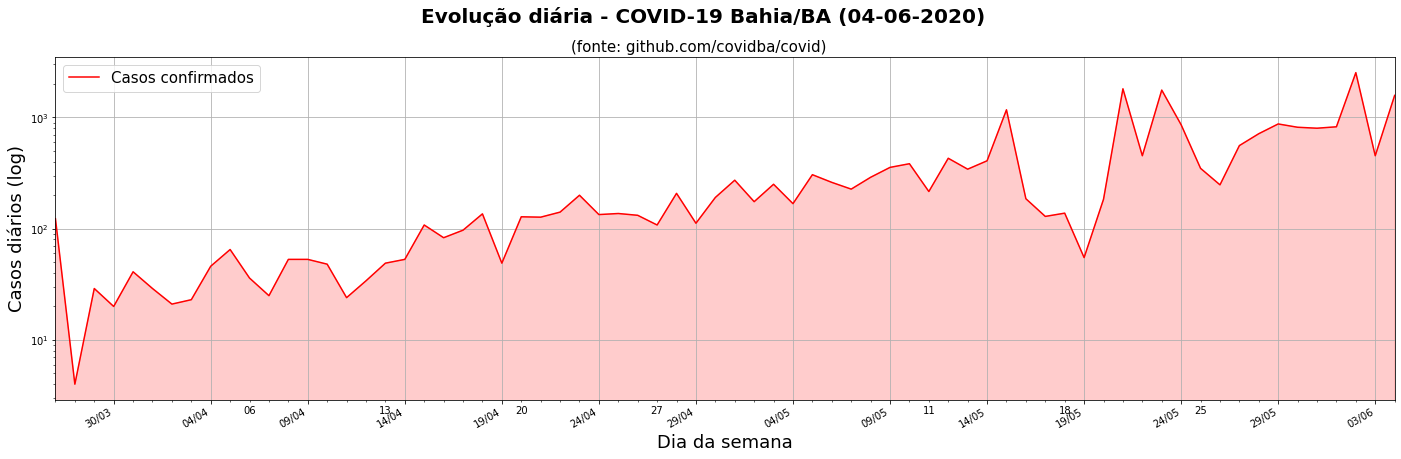

In [9]:
dict_diaria = dict()
dict_diaria['data'] = lista_data[:len(lista_data)-7]
dict_diaria['confirmados_diaria'] = casos_confirmados_diaria

df_diaria = pd.DataFrame(dict_diaria)
df_diaria.columns = ['data', 'Casos confirmados']

df_diaria.set_index('data', inplace=True)
fig, ax = plt.subplots(figsize=(24,7))
df_diaria.plot(ax=ax, color='r', kind='line')
fig.autofmt_xdate()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

#ax.axvline(linewidth=2, color='black', ls='--', x=dict_diaria['data'][45], ymax=0.9)
#ax.annotate('Dia sem dados fornecidos pela SESAB', xy=(dict_diaria['data'][45], 4), rotation=90,
#          xycoords='data', ha='center', fontsize=15, color='black',
#          xytext=(-10, 0), textcoords='offset points')

ax.fill_between(df_diaria.index, 0, df_diaria['Casos confirmados'], alpha=0.2, color='red')

#ax.set_ylim([0, df_diaria['Casos confirmados'].max()+15])
ax.set_xlim([lista_data.min(), lista_data.max()-timedelta(days=7)])
fig.suptitle("Evolução diária - COVID-19 %s/BA (%s)" % (cidade, df['data'].max().strftime("%d-%m-%Y")), fontsize=20, fontweight='bold')
ax.set_title("(fonte: %s)           " % url_fonte, fontsize=15)
ax.set_ylabel('Casos diários (log)', fontsize=18)
ax.set_xlabel('Dia da semana', fontsize=18)
ax.set_yscale('log')
ax.grid(True)

plt.savefig('/content/gdrive/My Drive/model/%s-evolucao-diaria.png' % cidade_file_name)

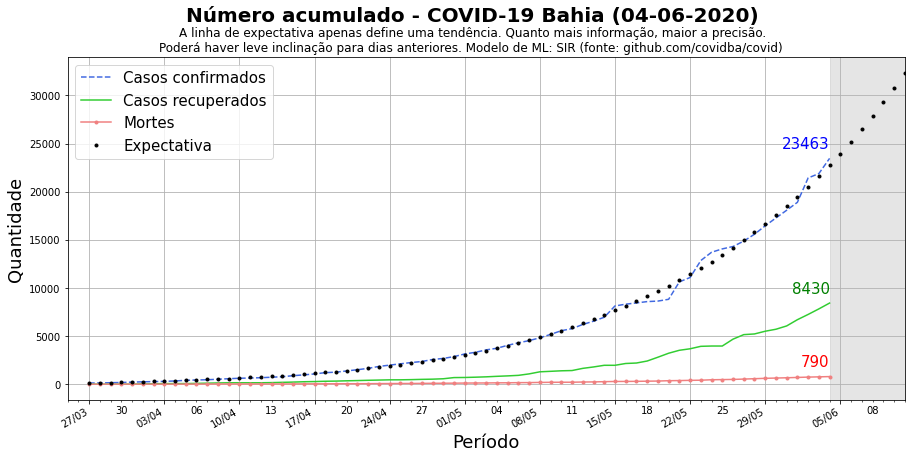

In [10]:
fig, ax = plt.subplots(figsize=(15,7))
colors = ['royalblue','limegreen','lightcoral', 'black']
ls = ['--', '-', '.-', '.']
new_df1 = new_df
if 'Casos ativos' in new_df1:
  del new_df1['Casos ativos']

new_df1.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# pintar área de projeção
ax.axvspan(df['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), lista_data.max().strftime("%Y-%m-%d"), 
           alpha=0.2, color='gray')

# ADICIONAR VALORES  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')

ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max()])
fig.suptitle("Número acumulado - COVID-19 %s (%s)" % (cidade, df['data'].max().strftime("%d-%m-%Y")), fontsize=20, fontweight='bold')
ax.set_title("A linha de expectativa apenas define uma tendência. Quanto mais informação, maior a precisão.       \nPoderá haver leve inclinação para dias anteriores. Modelo de ML: SIR (fonte: %s)        "  % url_fonte)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
plt.savefig('/content/gdrive/My Drive/model/%s-geral.png' % cidade_file_name)

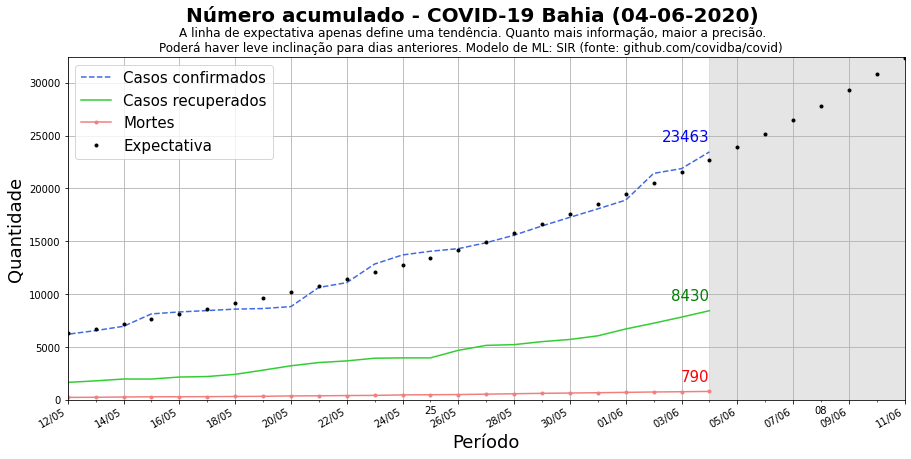

In [11]:
fig, ax = plt.subplots(figsize=(15,7))
new_df.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# pintar área de projeção
ax.axvspan(df['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), lista_data.max().strftime("%Y-%m-%d"), 
           alpha=0.2, color='gray')

# ADICIONAR VALORES
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')

ax.set_ylim([0, new_df['Expectativa'].max() + 70])
ax.set_xlim([lista_data.max() - timedelta(days=30), lista_data.max()])
fig.suptitle("Número acumulado - COVID-19 %s (%s)" % (cidade, df['data'].max().strftime("%d-%m-%Y")), fontsize=20, fontweight='bold')
ax.set_title("A linha de expectativa apenas define uma tendência. Quanto mais informação, maior a precisão.       \nPoderá haver leve inclinação para dias anteriores. Modelo de ML: SIR (fonte: %s)        "  % url_fonte)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
plt.savefig('/content/gdrive/My Drive/model/bahia-30-dias.png')